# Krista, working on linking CO and KO
13 August 2015, 20 August 2015

In [58]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal

%matplotlib inline

This version is using metabolites which can have isomers in KEGG, but are only found in either positive or negative ion mode (haven't dealt with the metabolites found in both yet.

In [66]:
#mtabFile = 'RImetabolites_unique.2015.08.19.csv' #this is the file with the mtabs that only have one isomer in KEGG
mtabFile = 'RImetabolites_isomers.2015.08.19.csv'

In [67]:
CO_RawData=pd.read_csv(mtabFile, index_col='cNumber')

In [60]:
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')

In [61]:
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]
CO_RawData=CO_RawData[CO_RawData.sum(axis=1)!=0]

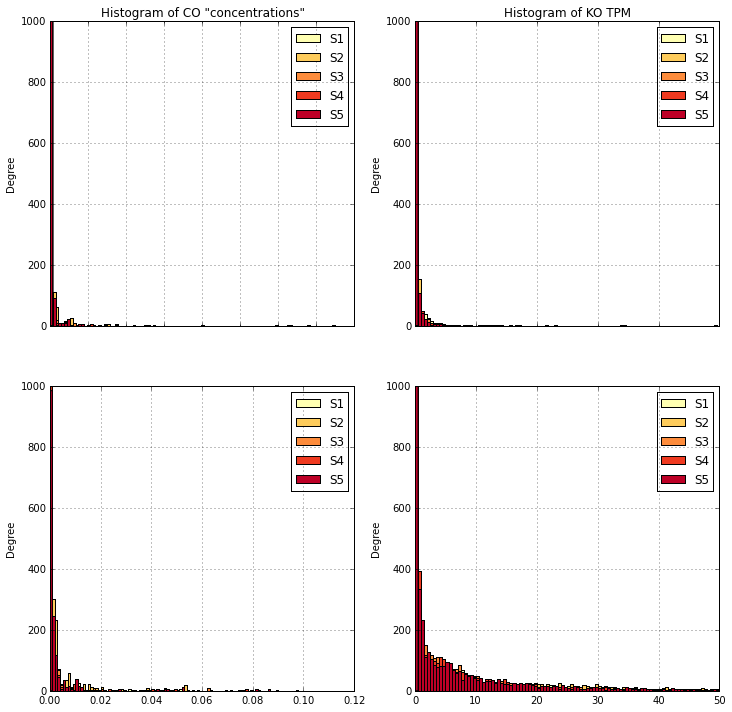

In [62]:
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
fig, axs=plt.subplots(2,2) 
fig.set_size_inches(12,12)
for ax in axs:
    for a in ax: 
        a.set_ylim([0,1000])
CO_RawData.plot(kind='hist', bins=100,colormap=cmap, ax=axs[0][0])
axs[0][0].set_title('Histogram of CO "concentrations"', size='large')
KO_RawData.plot(kind='hist', bins=100,colormap=cmap,ax=axs[0][1])
axs[0][1].set_title('Histogram of KO TPM', size='large')
CO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1],ax=axs[1][0])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50],ax=axs[1][1])

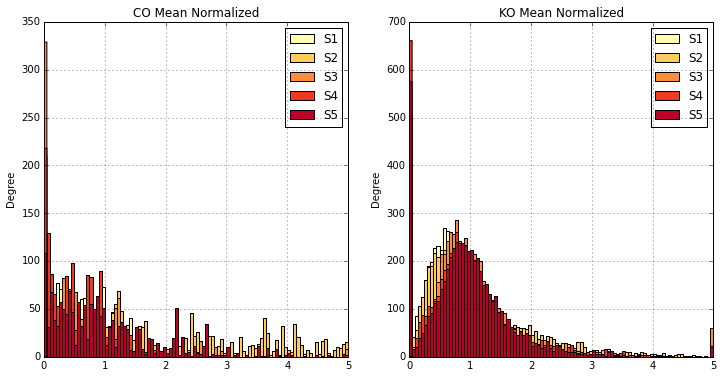

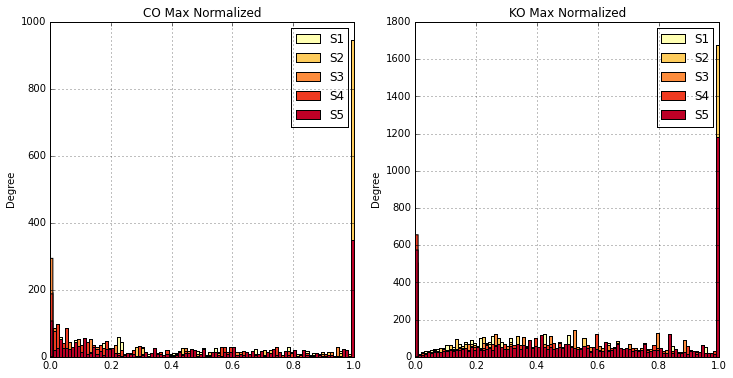

In [63]:
def NormalizeToMean(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['mean']=DF.mean(axis=1)

    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return out


def NormalizeToMax(DF):
    DF_meanNorm=DF.copy()
    out=DF_meanNorm.copy()
    DF_meanNorm['max']=DF.max(axis=1)
    for i in out.columns:
        out[i]=DF_meanNorm[i]/DF_meanNorm['max']
    DF_meanNorm=DF_meanNorm.T.drop('max').T
    return out

#several options for normalizing the data
CO_Norm2Mean=NormalizeToMean(CO_RawData) #this is what gets used in the original code
KO_Norm2Mean=NormalizeToMean(KO_RawData) #this is what gets used in the original code
CO_Norm2Max=NormalizeToMax(CO_RawData)
KO_Norm2Max=NormalizeToMax(KO_RawData)

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()

fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap, ax=axs[0])
fig, axs=plt.subplots(1,2) 
fig.set_size_inches(12,6)

kplt=KO_Norm2Max.plot(kind='hist', bins=100, title='KO Max Normalized', colormap=cmap, ax=axs[1])
cplt=CO_Norm2Max.plot(kind='hist', bins=100, title='CO Max Normalized', colormap=cmap, ax=axs[0])

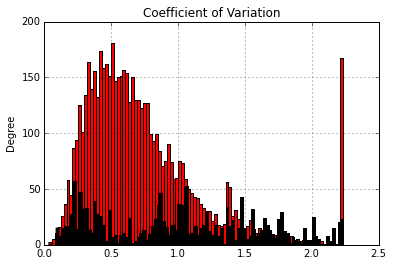

In [64]:
def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out

cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')



This grabs the CO/KO links from the KEGG website. The actual code is in the CreateHash_COtoKO.py that Harriet wrote

In [68]:
filename = "CreateHash_COtoKO.py"
%run $filename $mtabFile

0 C00047
100 C02526
200 C05478
300 C08585
400 C10173
500 C12259
600 C14654
700 C15129
800 C15999
900 C00019
1000 C02195
1100 C05003
1200 C08717
1300 C09674
1400 C11943
1500 C14963
1600 C17790


In [69]:
import cPickle as cpk

In [70]:
WorkingFile = cpk.load(open('running_Script.pickle','r'))

In [71]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an associated KO.', len(CO_withoutKO), 'are not associated with a KO.'



There are 303 COs with an associated KO. 1036 are not associated with a KO.


In [73]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()

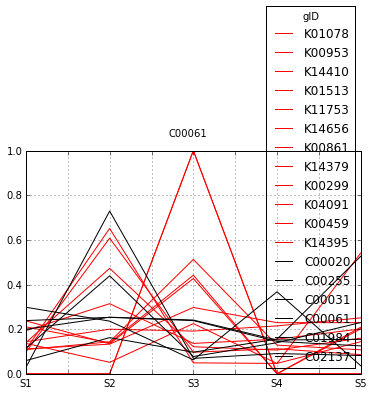

In [74]:
def PlotCompoundsKOs(InterestingCompounds):
    for i, CO in enumerate(InterestingCompounds):
        if i==20:
             break
        kos=CO_withKO[CO]['Related KO']
        cos=CO_withKO[CO]['Related CO']
        for k in kos: 
            if k in KO_RawData.index: 
                kData=KO_RawData.loc[kos].dropna()
                kData=(kData.T/kData.sum(axis=1)).T
                cData=CO_RawData.loc[cos].dropna()
                cData=(cData.T/cData.sum(axis=1)).T

                fig, ax=plt.subplots(1)
                kData.T.plot(color='r', ax=ax)
                cData.T.plot(color='k', ax=ax)
                fig.suptitle(CO)
                #fig.savefig(CO+'.png') #turn off the save bit for now
                break
                
   
IC=['C00061']
PlotCompoundsKOs(IC)             

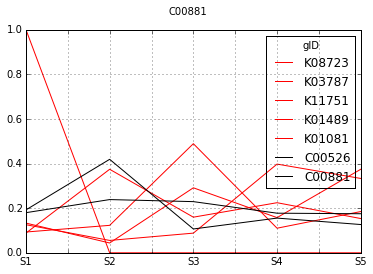

In [75]:
PlotCompoundsKOs(['C00881'])

In [91]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

def kmeanCluster(data,nc):
    kmeans=KMeans(n_clusters=nc)
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):

    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
         #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Module created for script run in IPython


So...how do we actually decide how many clusters are best? Using silhoette analysis, looking for high silhouette_scores. 

For n_clusters = 14 The average silhouette_score is : 0.263059076937


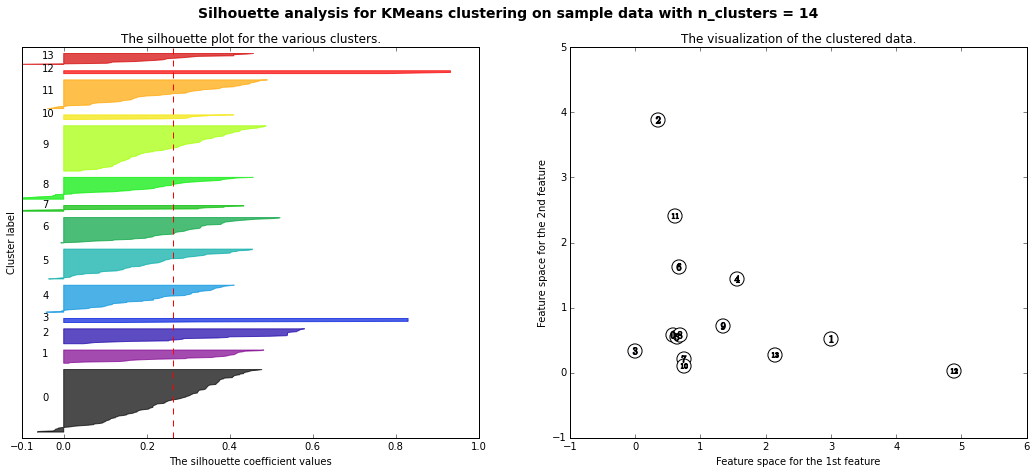

For n_clusters = 15 The average silhouette_score is : 0.260230036753


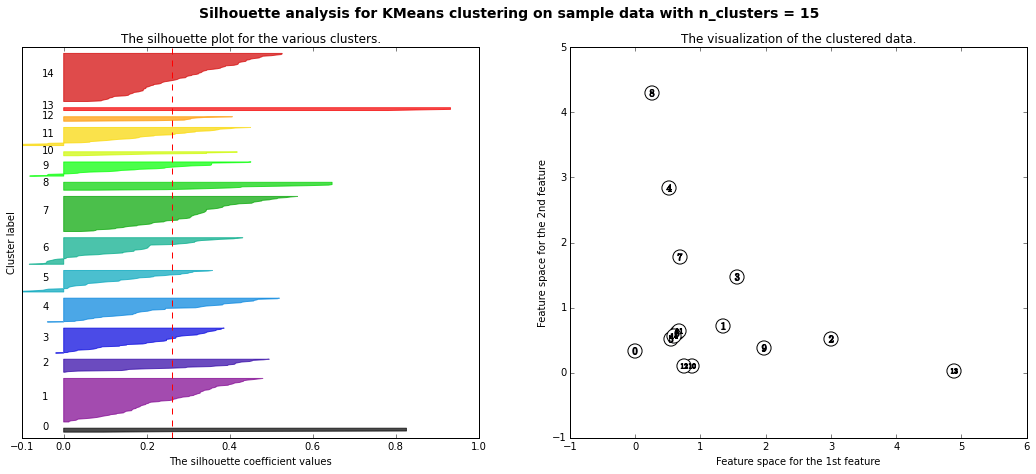

In [229]:
#Silhoette data to determine optimal number of clusters. Start with the KO data
silhoetteAnalysis(KO_limited_Norm2Mean, np.arange(14,16,1))

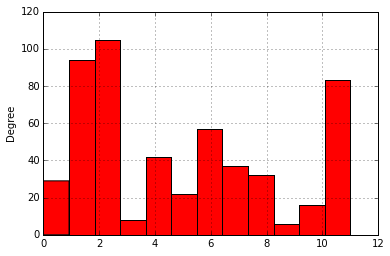

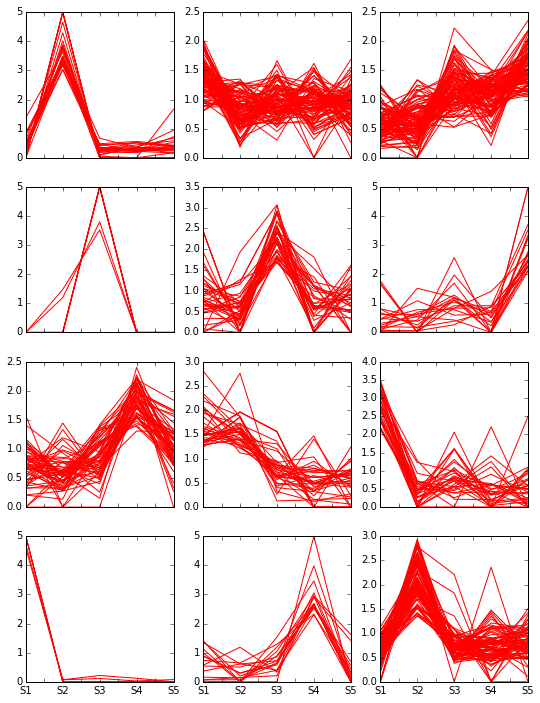

In [140]:
#plot it up...what is degree?
#koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
#PlotKmeans(koClust,15,3,5, 'r') 
koClust=kmeanCluster(KO_limited_Norm2Mean, 12)
PlotKmeans(koClust,12,4,3, 'r') 


For n_clusters = 14 The average silhouette_score is : 0.444827188186


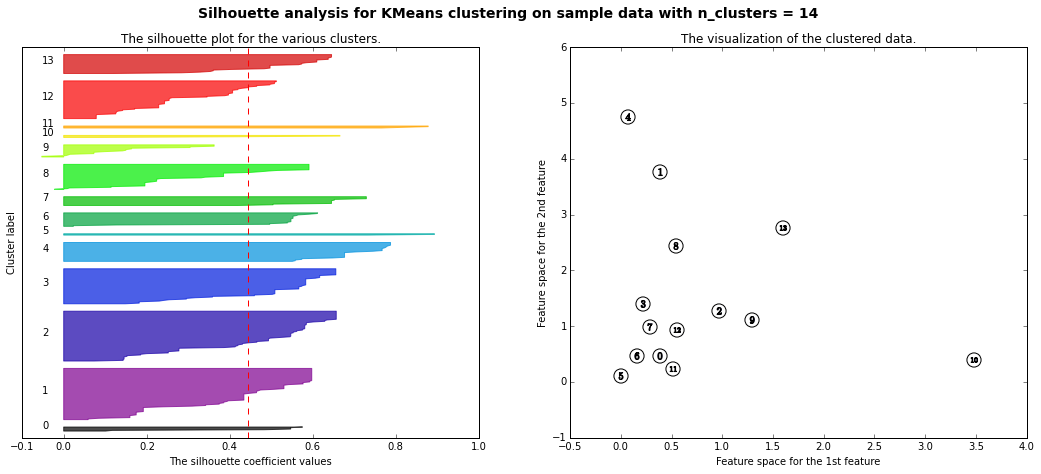

For n_clusters = 15 The average silhouette_score is : 0.436342771259


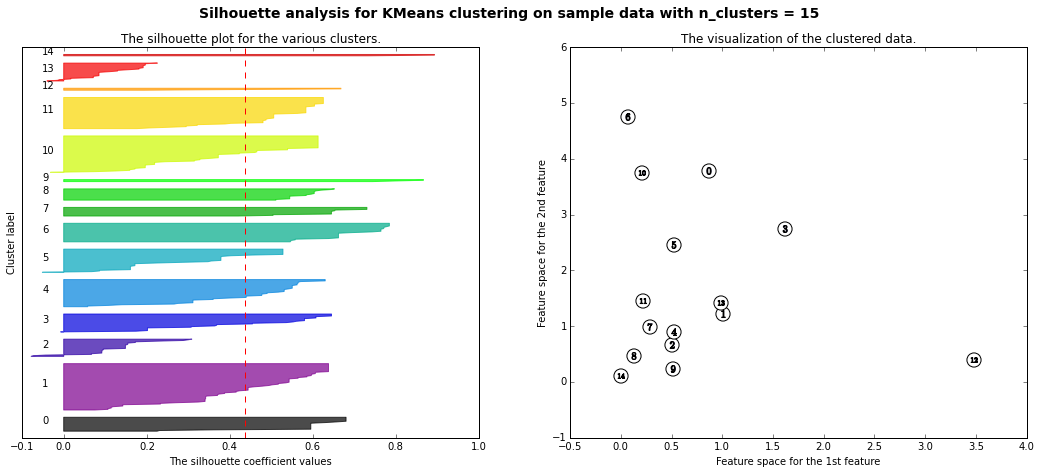

In [230]:
#now do the CO data
#silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(2,20,1)) #KL trying a large range of options
silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(14,16,1))

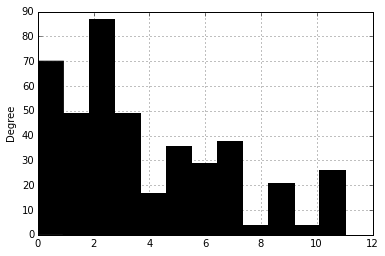

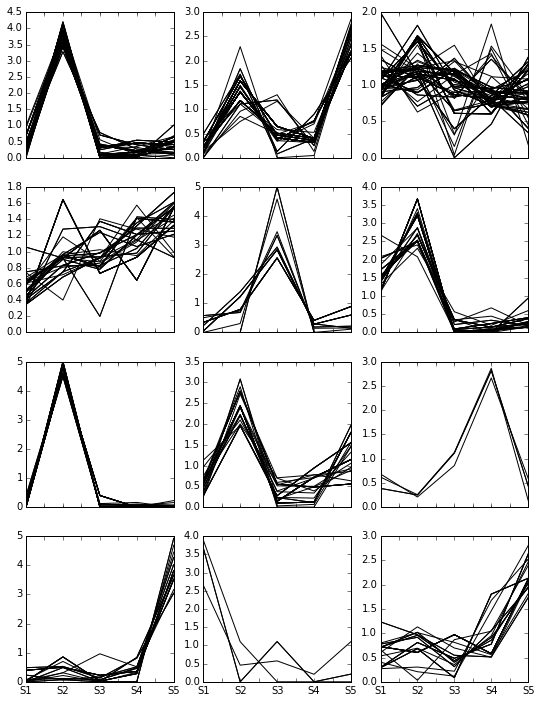

In [141]:
#coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
#PlotKmeans(coClust,15,3,5, 'k') 
coClust=kmeanCluster(CO_limited_Norm2Mean, 12)
PlotKmeans(coClust,12,4,3, 'k') 

From HA: By normalizing the data to the mean we can then (in theory) combine the two and cluster them together?
KL 8/20/2015 note: this is essentially a list with the CO and KO concatenated into a single data frame. Note that the actual kmeans clustering does not happen until after the silhoette analysis.

For n_clusters = 2 The average silhouette_score is : 0.422763494554


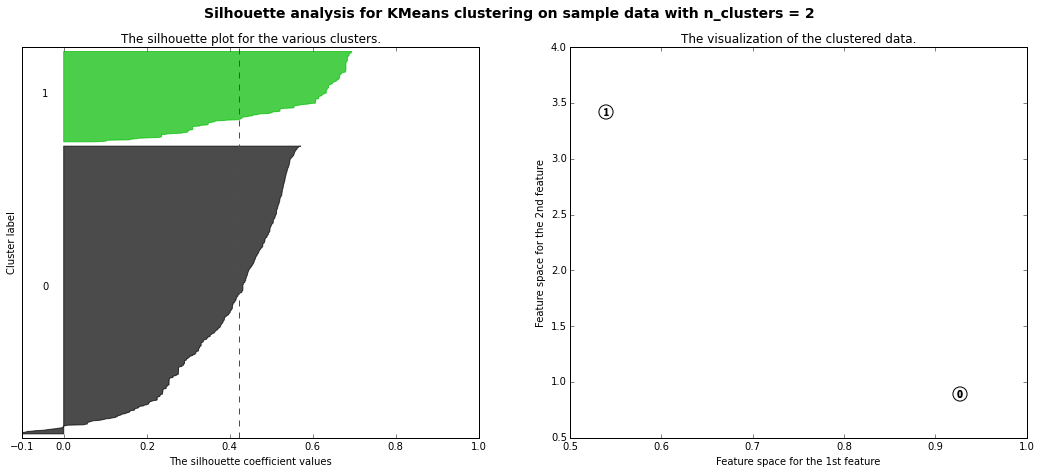

For n_clusters = 3 The average silhouette_score is : 0.332039872321


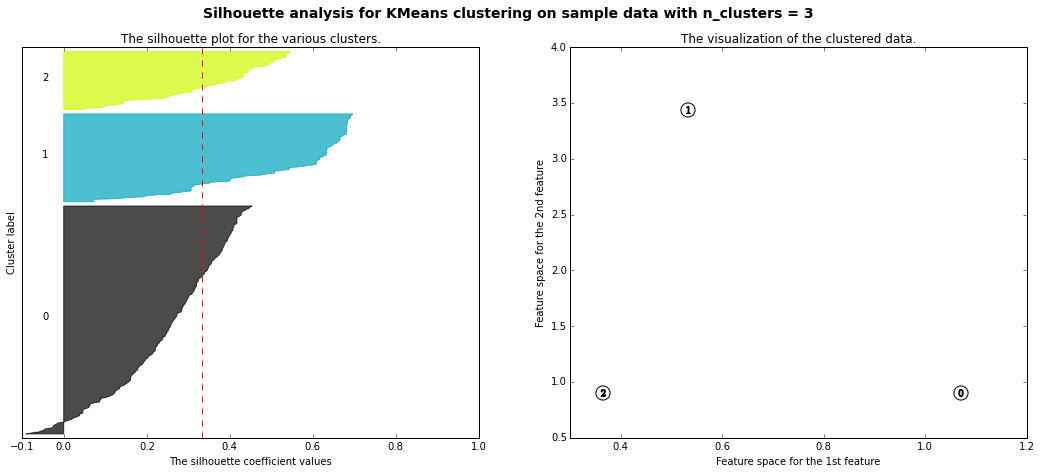

For n_clusters = 4 The average silhouette_score is : 0.355000232991


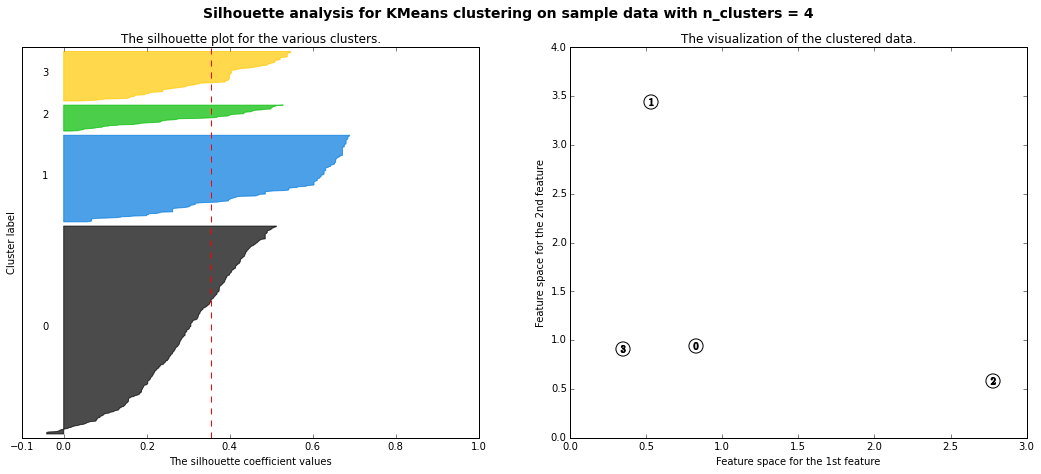

For n_clusters = 5 The average silhouette_score is : 0.376334545546


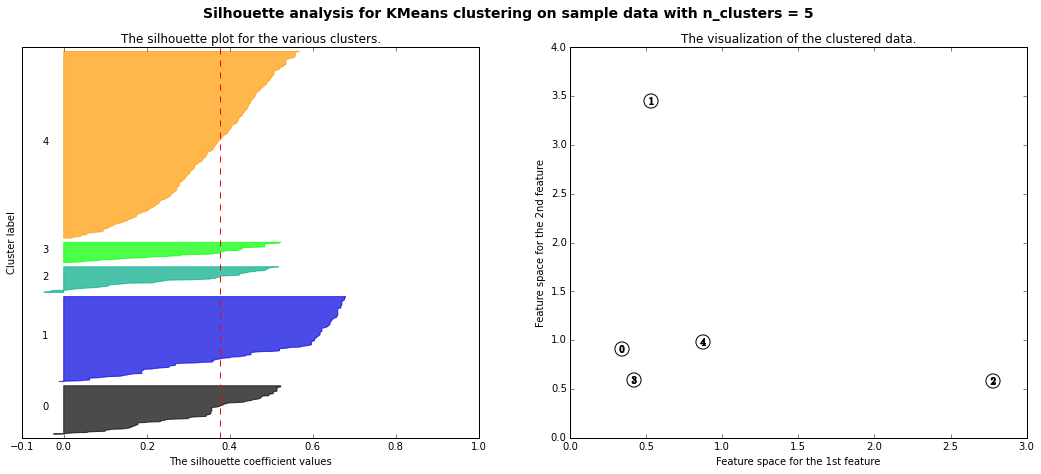

For n_clusters = 6 The average silhouette_score is : 0.336231236304


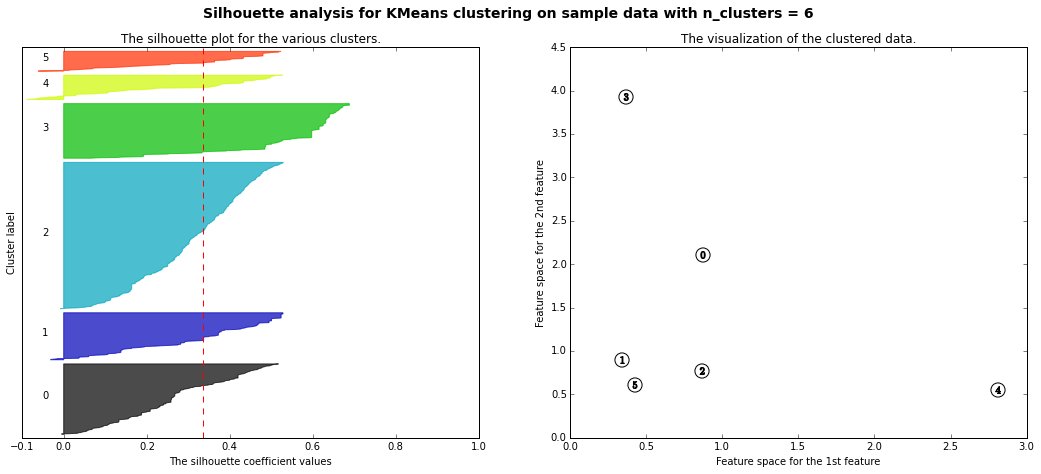

For n_clusters = 7 The average silhouette_score is : 0.30029744845


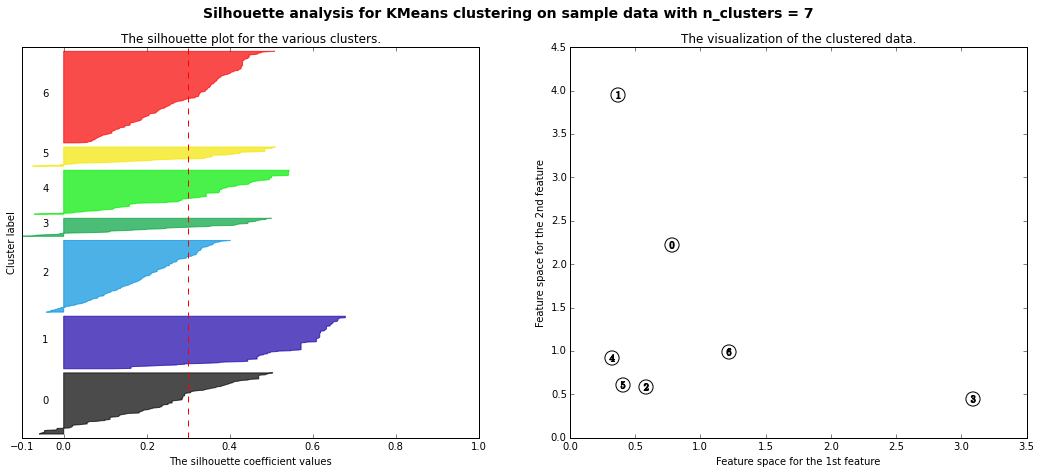

For n_clusters = 8 The average silhouette_score is : 0.304162404394


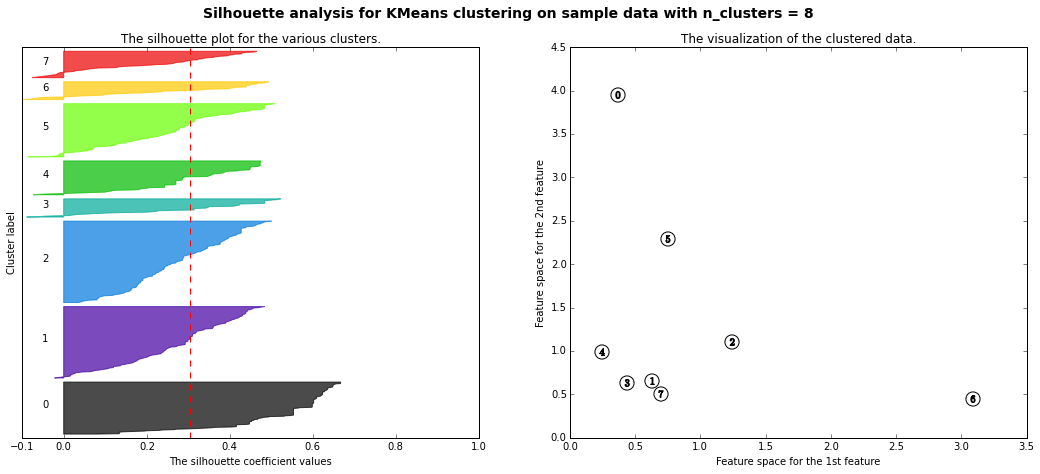

For n_clusters = 9 The average silhouette_score is : 0.309940144208


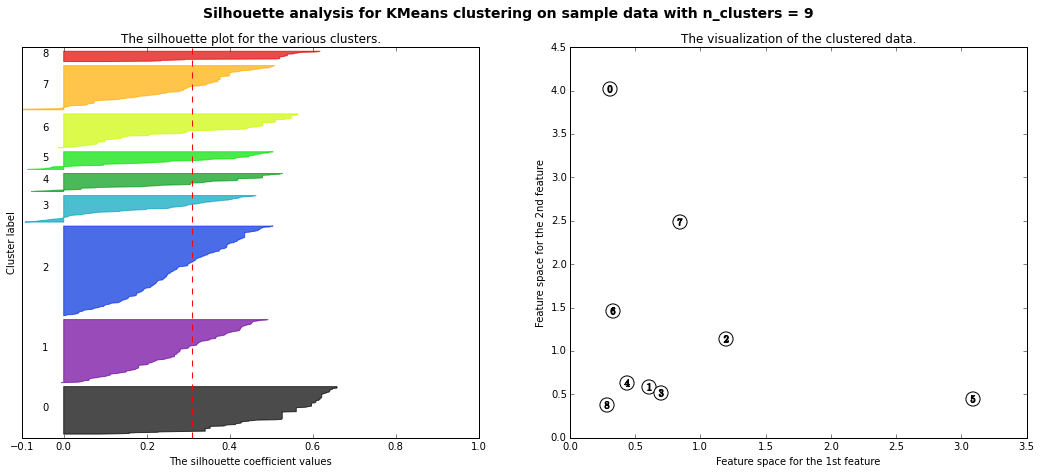

For n_clusters = 10 The average silhouette_score is : 0.314037089448


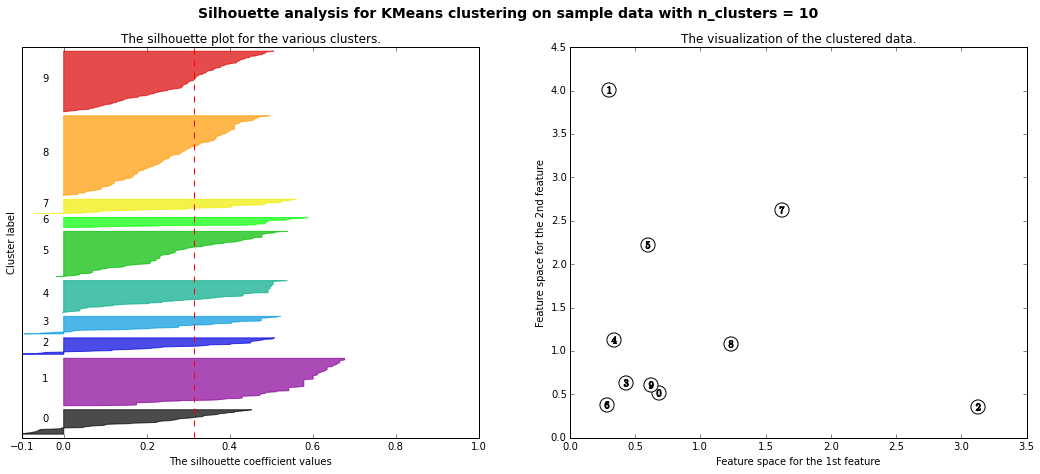

For n_clusters = 11 The average silhouette_score is : 0.304674428434


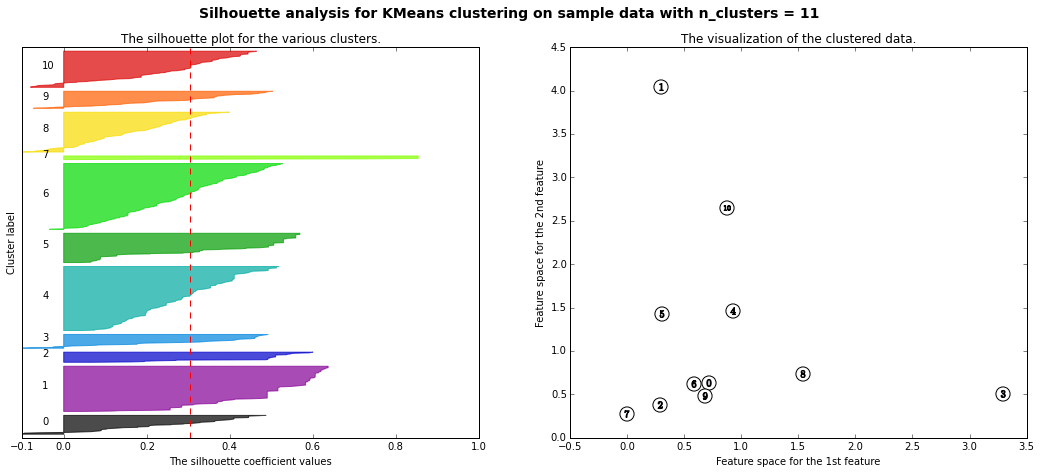

For n_clusters = 12 The average silhouette_score is : 0.299089364858


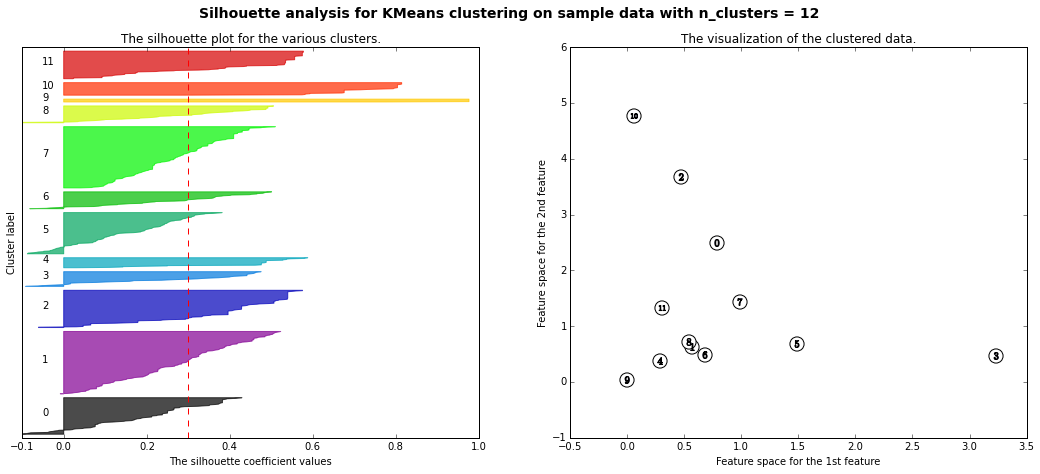

For n_clusters = 13 The average silhouette_score is : 0.304588220608


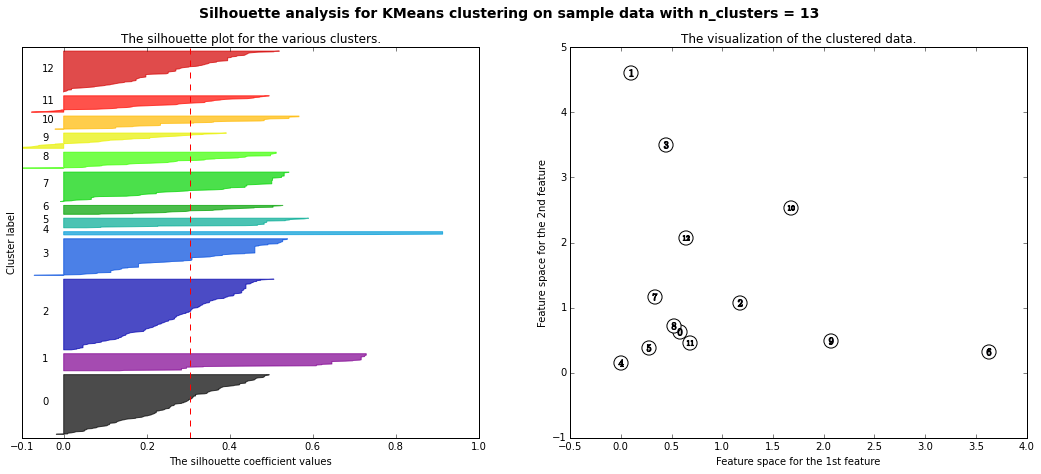

For n_clusters = 14 The average silhouette_score is : 0.298454273088


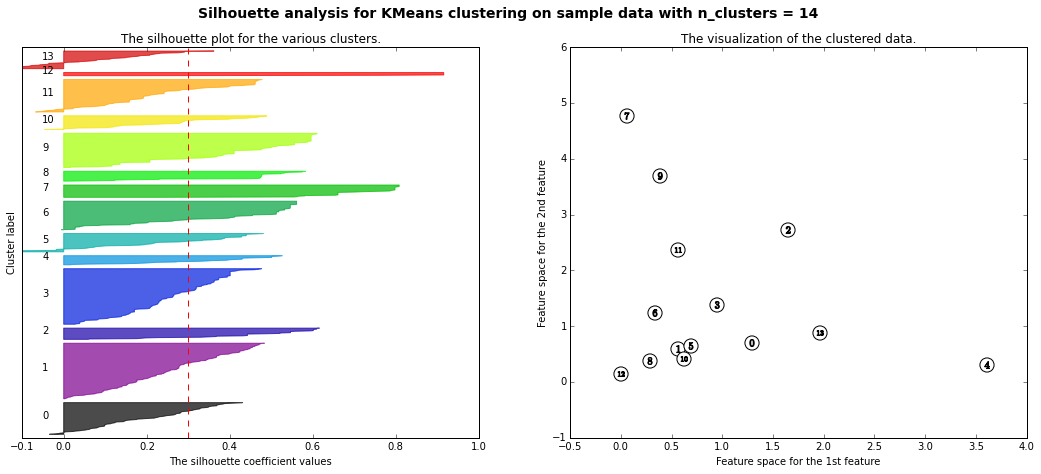

For n_clusters = 15 The average silhouette_score is : 0.290049020073


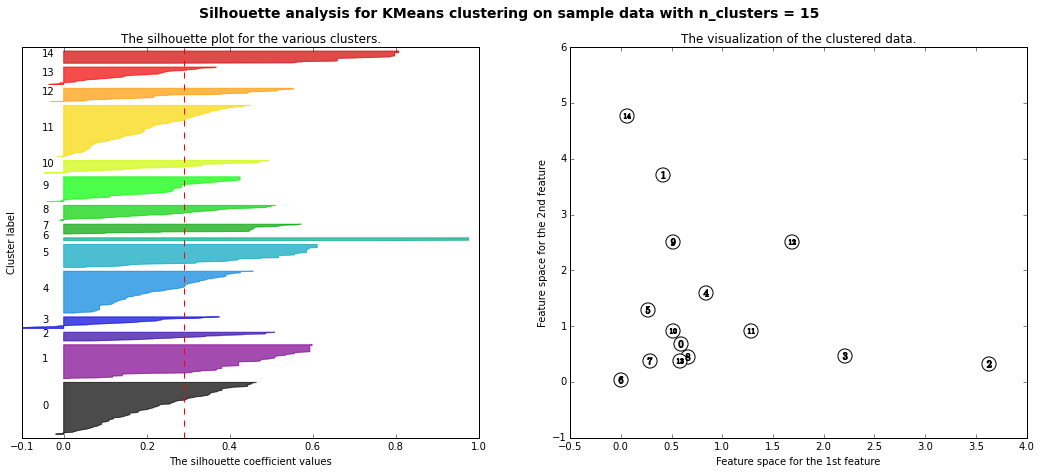

For n_clusters = 16 The average silhouette_score is : 0.301859958146


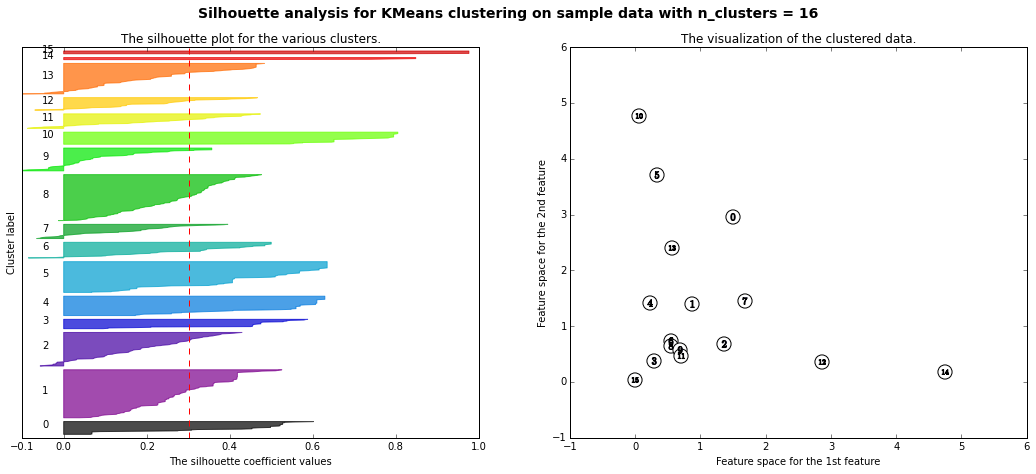

For n_clusters = 17 The average silhouette_score is : 0.277639034697


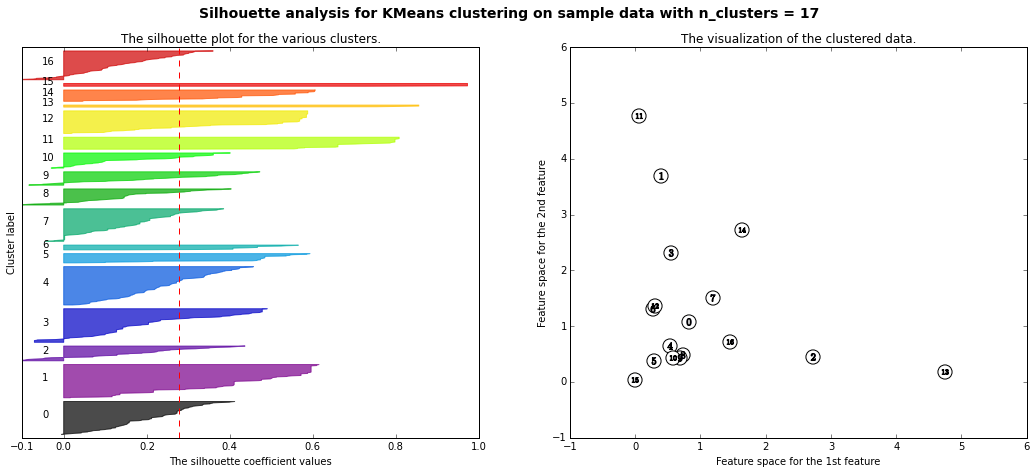

For n_clusters = 18 The average silhouette_score is : 0.297453083338


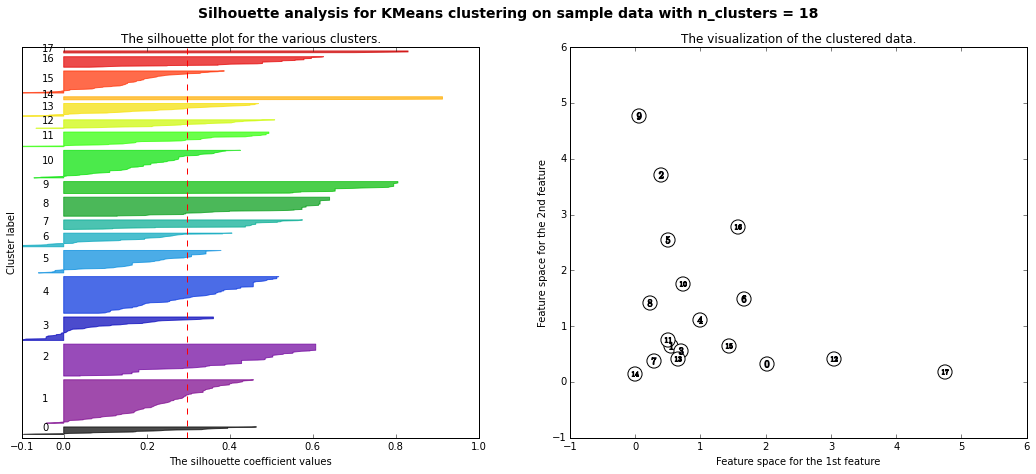

For n_clusters = 19 The average silhouette_score is : 0.292581662798


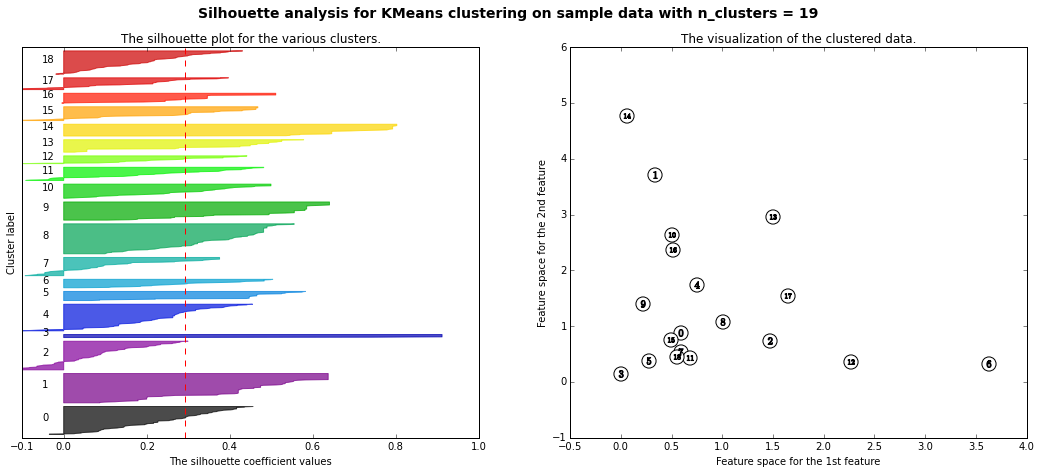

For n_clusters = 20 The average silhouette_score is : 0.297521920795


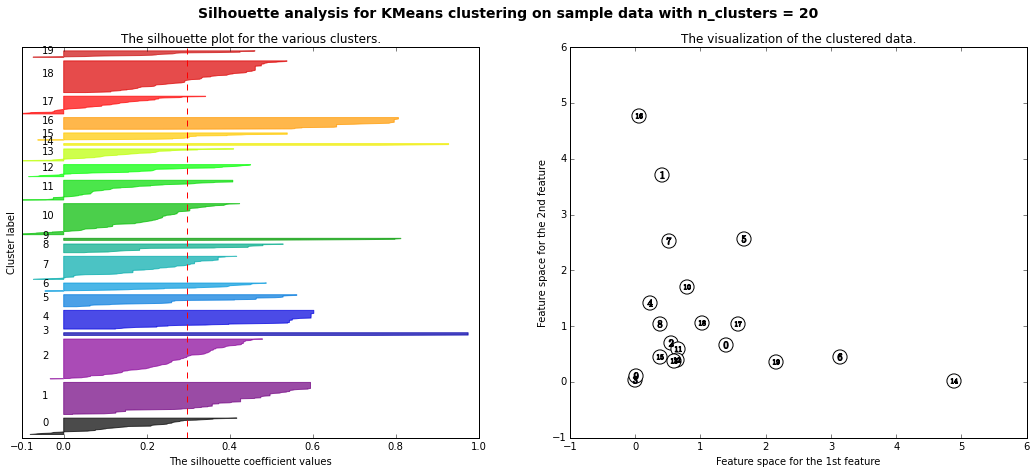

In [137]:
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
# Combined_KO_CO_MeanNorm=Combined_KO_CO_MeanNorm-Combined_KO_CO_MeanNorm.mean()
#Run silhoette analysis
#silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(15,19,1))
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(2,21,1))

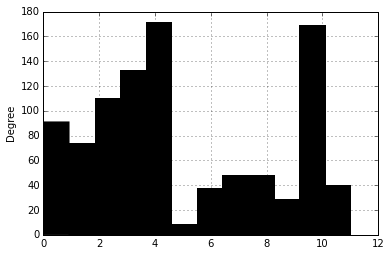

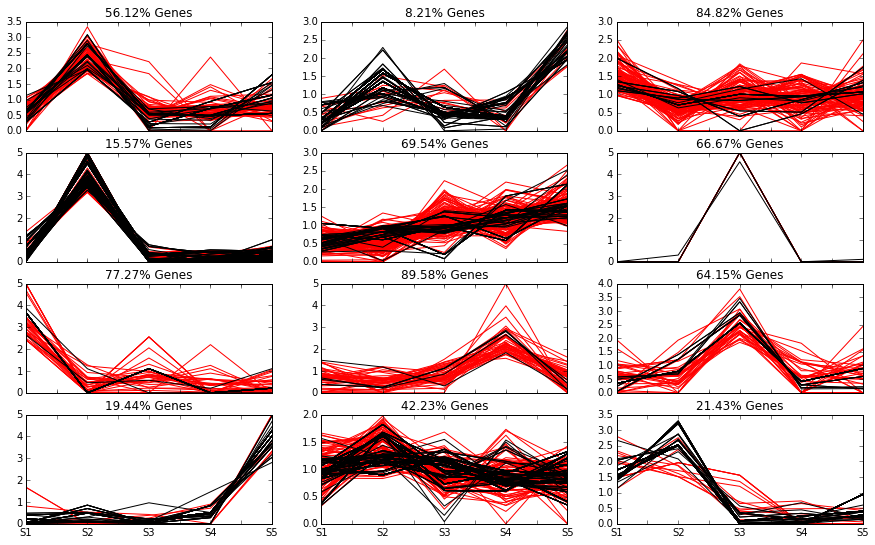

In [253]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    Cs=re.compile('C.*')
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title(str(round(KPct,2))+'% Genes')
    
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, 12) #was 18 
#PlotKmeansCombined(CcoClust,18,3,6, 'r') 
PlotKmeansCombined(CcoClust,12,4,3, 'r') 

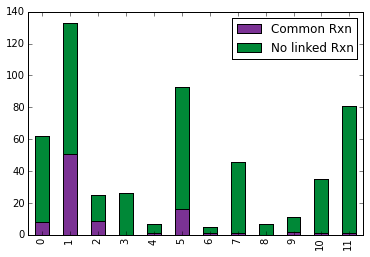

In [144]:
def CheckRelatedness(inClust,nC):
    df=pd.DataFrame(columns=['Common Rxn','No linked Rxn'], index=range(nC))
    for n in range(nC):
        kClust=inClust[inClust.kmeans==n]
        i=kClust.index
        i=list(i)
        Csearc=re.compile('C.*')
        Cs = filter(Csearc.search, i)
        Ksearc=re.compile('K.*')
        Kis = filter(Ksearc.search, i)
        Kis=set(Kis)
        Ks=[]
        for c in Cs:
            if c in CO_withKO.keys():
                Ks.append(CO_withKO[c]['Related KO'])
        Ks=set([item for sublist in Ks for item in sublist])
        df.loc[n,'Common Rxn']=len(Kis.intersection(Ks))
        df.loc[n, 'No linked Rxn']=len(Kis)-len(Kis.intersection(Ks))
    df.plot(kind='bar', stacked=True, colormap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap(), grid=False)
    
    
CheckRelatedness(CcoClust, 12)

Seems like I want to plot the various CO/KO combined plots by clusters shown in the k-means clustering.

In [228]:
#this will allow me to select only the first group in the kmeans clusters (baby steps)
CcoClust[CcoClust.kmeans==1]

,S1,S2,S3,S4,S5,kmeans
K17687,0.471030,0.484041,1.538987,1.363316,1.142626,1
K00758,0.324290,1.332995,0.491931,1.706549,1.144235,1
K00503,0.414525,1.336715,0.789500,1.064815,1.394446,1
K00469,1.247639,0.262858,1.356559,0.361244,1.771701,1
K12349,0.855746,0.631395,1.260515,1.105349,1.146994,1
K08680,0.395748,0.392158,1.039041,1.405759,1.767294,1
K11751,0.629380,0.277185,0.440641,1.987241,1.665553,1
K15718,0.965845,0.364597,1.593931,0.980228,1.095399,1
K13499,0.745420,0.601155,1.118339,1.535966,0.999120,1
K18134,1.211422,0.457302,0.908735,0.819639,1.602902,1


In [192]:
#CO_withKO.keys() #this will list all the keys
CO_withKO['C05488'] #this will spit out the information for one C #

{'Modules': ['M00109'],
 'Name': 'C05488',
 'Reaction': {'R02843': {'CO': ['C05488',
    'C00138',
    'C00007',
    'C00080',
    'C00735',
    'C00139',
    'C00001'],
   'KO': ['K00497', 'K07433']},
  'R03326': {'CO': ['C01176',
    'C00030',
    'C00007',
    'C05488',
    'C00028',
    'C00001'],
   'KO': ['K00513']},
  'R04849': {'CO': ['C05488', 'C00080', 'C00004', 'C05487', 'C00003'],
   'KO': ['K00070', 'K01822']}},
 'Related CO': ['C00004',
  'C00030',
  'C00139',
  'C00080',
  'C05488',
  'C00138',
  'C00003',
  'C00028',
  'C00001',
  'C00735',
  'C00007',
  'C01176',
  'C05487'],
 'Related KO': ['K01822', 'K00513', 'K00497', 'K07433', 'K00070']}

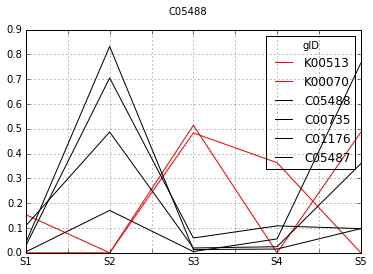

In [206]:
#for i, CO in enumerate(CO_withKO):
#for i in range(1): #this allows me to only run one file... [MATLAB would be: for a = 1]
for i in range(1):
    if i==20:
         break
    kos=CO_withKO[CO]['Related KO']
    cos=CO_withKO[CO]['Related CO']
    for k in kos: 
        if k in KO_RawData.index: 
            kData=KO_RawData.loc[kos].dropna()
            kData=(kData.T/kData.sum(axis=1)).T
            cData=CO_RawData.loc[cos].dropna()
            cData=(cData.T/cData.sum(axis=1)).T

            fig, ax=plt.subplots(1)
            kData.T.plot(color='r', ax=ax)
            cData.T.plot(color='k', ax=ax)
            fig.suptitle(CO)
            #fig.savefig(CO+'.png') #stop saving all the images for now...
            break

What would be nice is to group the plots from the related compounds by cluster...

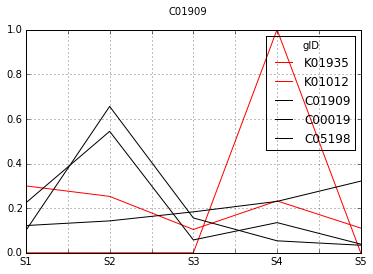

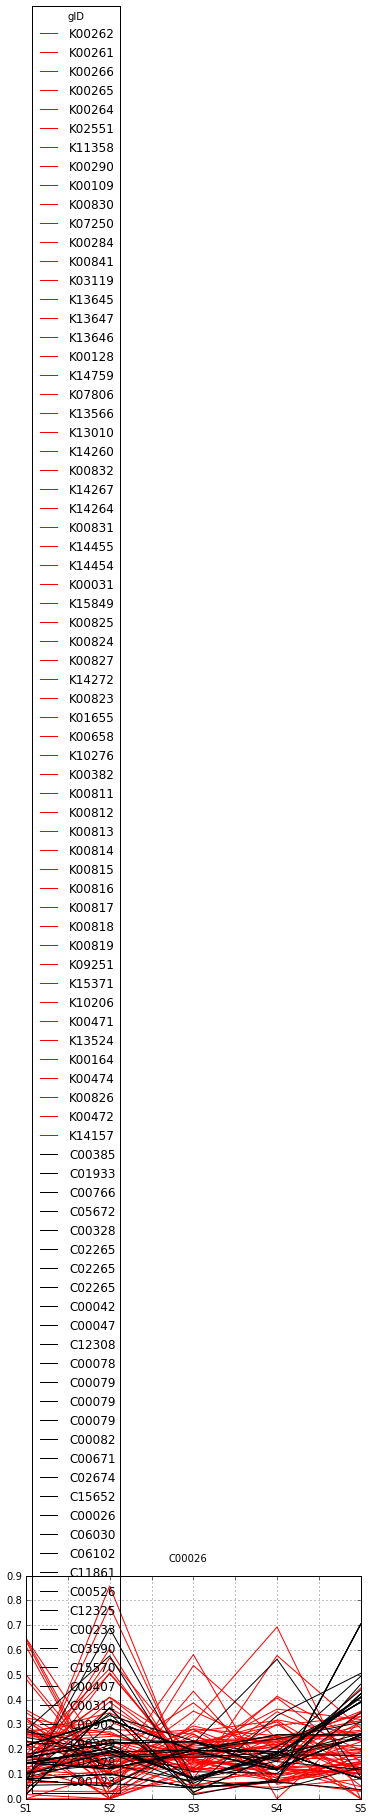

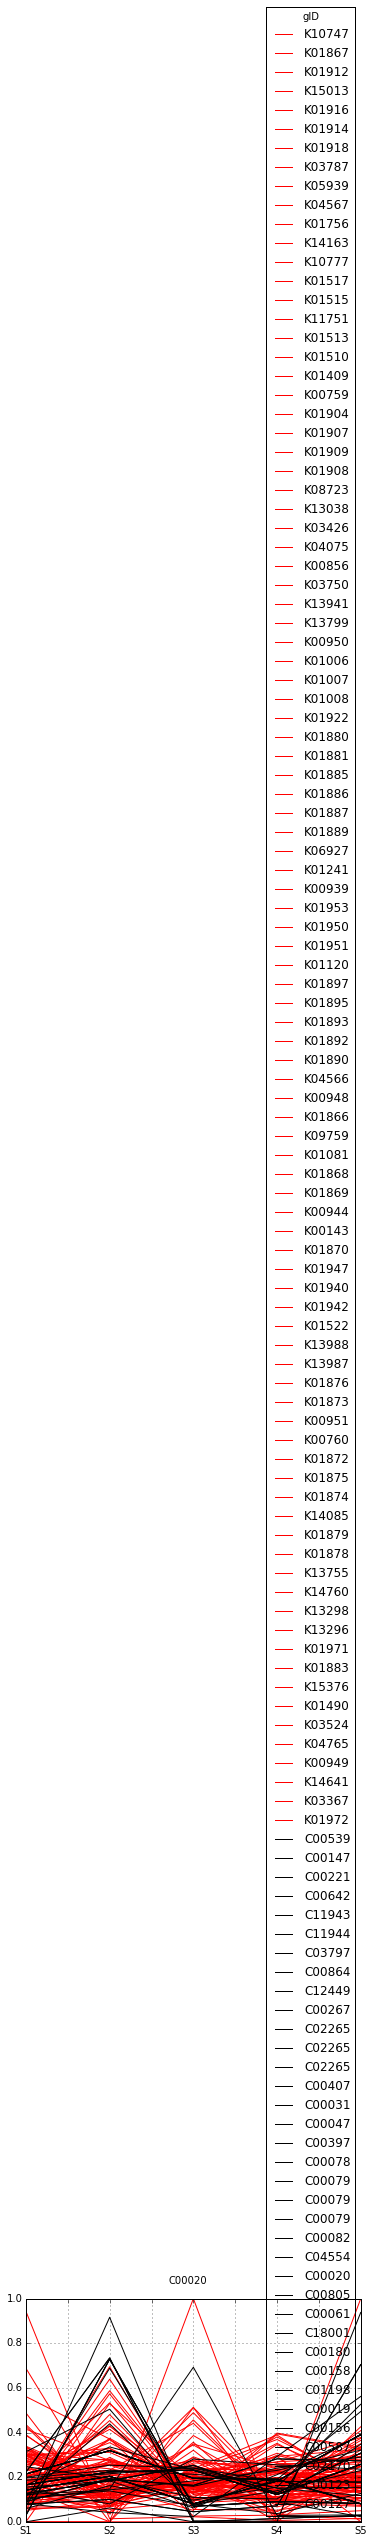

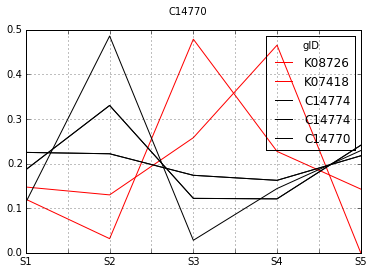

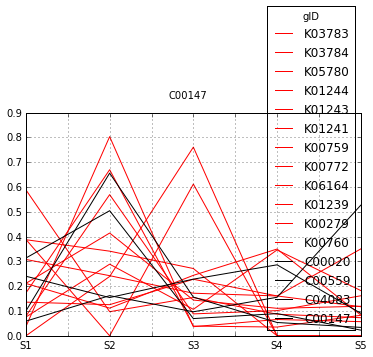

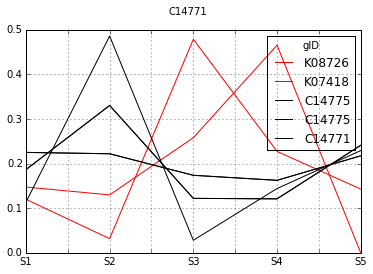

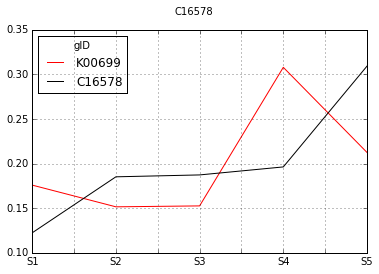

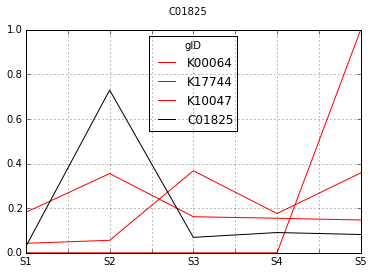

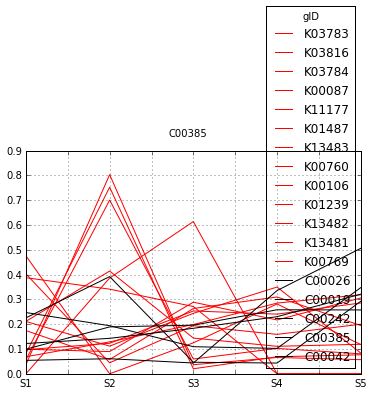

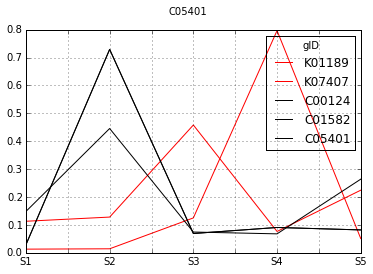

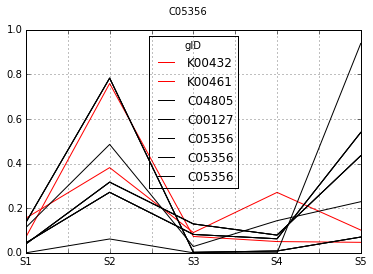

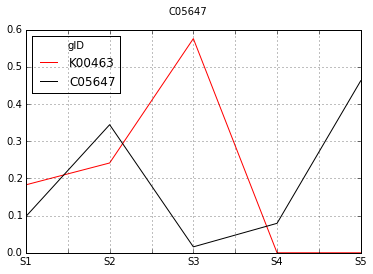

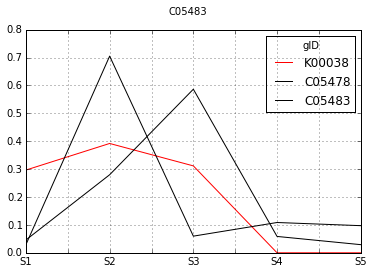

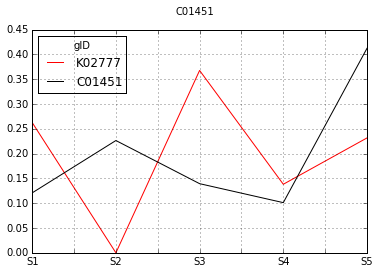

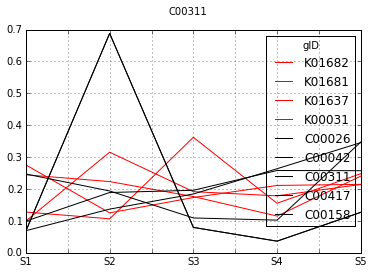

In [127]:
for i, CO in enumerate(CO_withKO):
    if i==20:
         break
    kos=CO_withKO[CO]['Related KO']
    cos=CO_withKO[CO]['Related CO']
    for k in kos: 
        if k in KO_RawData.index: 
            kData=KO_RawData.loc[kos].dropna()
            kData=(kData.T/kData.sum(axis=1)).T
            cData=CO_RawData.loc[cos].dropna()
            cData=(cData.T/cData.sum(axis=1)).T

            fig, ax=plt.subplots(1)
            kData.T.plot(color='r', ax=ax)
            cData.T.plot(color='k', ax=ax)
            fig.suptitle(CO)
            fig.savefig(CO+'.png')
            break

In [128]:
len(CO_withKO)

303

In [129]:
for i,CO in enumerate(CO_withKO):
    kos = CO_withKO[CO]['Related KO']
    cos = CO_withKO[CO]['Related CO']
    for k in kos:
        if k in KO_RawData.index:
            kData=KO_RawData.loc[kos].dropna()
            kData=(kData.T/kData.sum(axis=1)).T
            cData=CO_RawData.loc[cos].dropna()
            

In [130]:
kData

,S1,S2,S3,S4,S5
gID,,,,,
K02474,0.382534,0.126355,0.301303,0.000000,0.189808
K13499,0.149084,0.120231,0.223668,0.307193,0.199824
